In [1]:
import init_notebook

# Task 2 - Diffusion Maps

This task focuses on dimensionality reduction using diffusion maps.

In [49]:
%load_ext autoreload
%autoreload 2
import numpy as np
import math as m
import matplotlib.pyplot as plt
from difusion_maps import diffusion_map
from sklearn.datasets import make_swiss_roll
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting
import pandas as pd


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Part 1
In this part of the task a dataset is created with the following formula:
$$
X = \{x_k\in \R^2\}_{k=1}^{N} \\
$$
$$
x_k = (\cos(t_k), \sin(t_k)) \\
$$
$$
t_k = \frac{2\pi k}{N+1}
$$

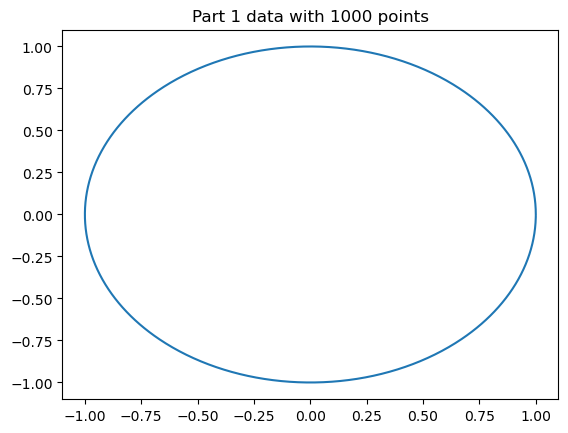

In [24]:
N = 1000

def t(k: int) -> float:
    return (2 * m.pi * k) / (N + 1)

data_x = np.cos(np.array(
    [t(k) for k in range(N)], dtype=np.float64
))

data_y = np.sin(np.array(
    [t(k) for k in range(N)], dtype=np.float64
))

data = np.dstack((data_x, data_y))[0]
plt.plot(data_x, data_y)
plt.title(f"Part 1 data with {N} points")
plt.show()

In [4]:
eigen_values, eigen_vectors = diffusion_map(data, num_eigenvalues=-1)

for value in eigen_values:
    print(value)


c:\Users\Lenovo\.conda\envs\MLCMS_GroupI\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
c:\Users\Lenovo\.conda\envs\MLCMS_GroupI\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


(1+0j)
(0.9697300290017049+0j)
(0.9697222645694882+0j)
(0.8842172210726092+0j)
(0.8841729420382121+0j)
(0.7578615629145679+0j)
(0.7577264199578788+0j)
(0.6102604036573271+0j)
(0.6099717630020938+0j)
(0.4613242028833287+0j)
(0.4608475878491469+0j)
(0.3270582583509024+0j)
(0.32641557807710353+0j)
(0.2171766228019236+0j)
(0.21644496703425137+0j)
(0.13485783812216778+0j)
(0.13413954440295453+0j)
(0.07815706628110658+0j)
(0.07754054743499222+0j)
(0.04217648724603361+0j)
(0.041709729221705995+0j)
(0.021133292913597213+0j)
(0.020819876094782027+0j)
(0.009799808883664694+0j)
(0.009612596409367695+0j)
(0.0041890942082440045+0j)
(0.004089516104313042+0j)
(0.0016431171992645794+0j)
(0.001595986147338952+0j)
(0.000588160478573453+0j)
(0.0005683551566513836+0j)
(0.00019089783249580345+0j)
(0.00018353696925326146+0j)
(5.5750933575595275e-05+0j)
(5.334453101716426e-05+0j)
(1.4516323009913799e-05+0j)
(1.3829397497663397e-05+0j)
(3.3326076604262718e-06+0j)
(3.1630169861814332e-06+0j)
(6.654608982601917

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16736\1414145546.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X[:, 0], X[:, 1], X[:, 2], c='blue', cmap='viridis', s=20)


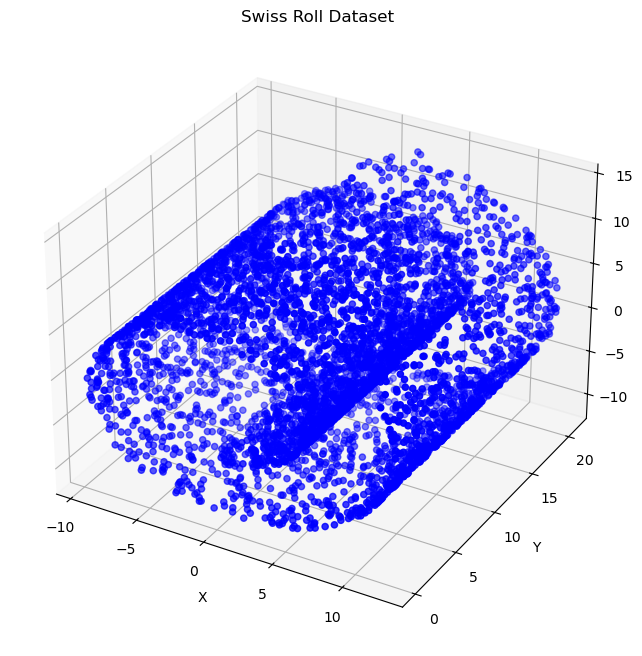

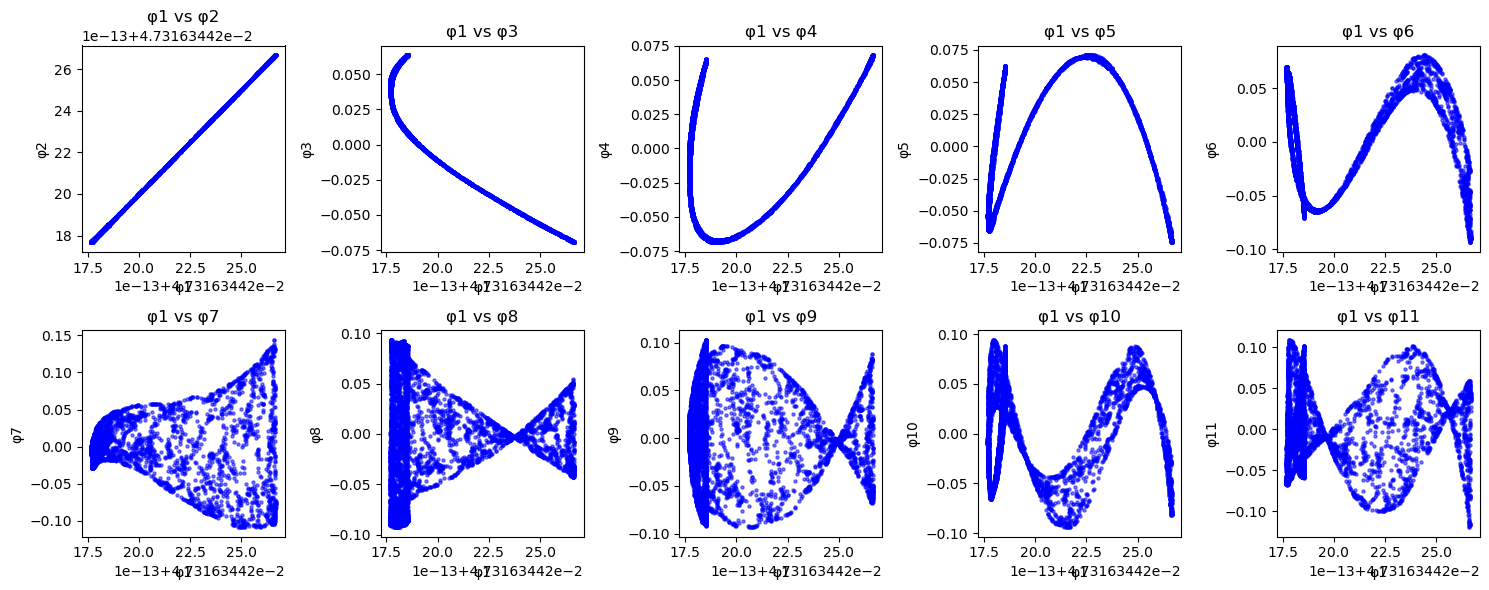

c:\Users\Lenovo\.conda\envs\MLCMS_GroupI\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
c:\Users\Lenovo\.conda\envs\MLCMS_GroupI\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


In [51]:
# Step 1: Generate the "swiss roll" dataset
np.random.seed(42)  # Set a seed for reproducibility
X, _ = make_swiss_roll(n_samples=5000)

# Step 1.1: Plot the initial 3D "swiss roll" dataset
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c='blue', cmap='viridis', s=20)
ax.set_title("Swiss Roll Dataset")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

# Step 2: Apply the diffusion maps algorithm
eigenvalues, eigenvectors = diffusion_map(X, diameter_percent=0.05, num_eigenvalues=10)

# Step 3: Plot the first non-constant eigenfunction against other eigenfunctions
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flatten()):
    ax.scatter(eigenvectors[:, 0], eigenvectors[:, i], s=5, c='blue', alpha=0.5)
    ax.set_title(f'φ1 vs φ{i + 2}')
    ax.set_xlabel('φ1')
    ax.set_ylabel(f'φ{i + 2}')

plt.tight_layout()
plt.show()

# Step 4: Determine when φl, l > 1 is no longer a function of φ1
# You may visually inspect the plots to identify the point where the relationship changes.

# Step 5: Compute the three principal components of the "swiss roll" dataset
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

# Step 6: Discuss why it's impossible to represent the data using only two principal components.

# Step 7: Investigate the effect of using only 1000 data points
X_1000, _ = make_swiss_roll(n_samples=1000)
eigenvalues_1000, eigenvectors_1000 = diffusion_map(X_1000, diameter_percent=0.05, num_eigenvalues=10)


In [47]:
# read the trajectories data
trajs = pd.read_csv("../data/data_DMAP_PCA_vadere.txt", header=None, sep=" ")
trajs.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,7.682746,16.590135,13.483825,16.516303,4.094633,12.947896,6.185209,14.051827,2.384750,11.906402,...,7.618038,14.830008,5.793517,7.085613,13.165387,18.276296,10.980464,17.096179,5.906016,15.322550
1,8.145535,16.648409,13.277208,16.328543,4.044564,12.747607,6.039434,14.420585,2.158819,11.833650,...,7.307820,14.957749,5.541795,7.212933,13.209182,18.195222,11.202859,17.305462,5.822190,15.679348
2,7.887370,16.508989,13.481755,16.028657,3.819413,13.021751,5.865487,14.156773,1.987087,11.675436,...,7.386211,14.685901,5.426626,7.085823,13.417320,18.207198,11.005363,17.370636,5.552942,15.409457
3,7.946284,16.306714,13.712739,16.406934,4.325781,12.930226,5.501616,14.330293,1.944104,11.744856,...,7.323483,14.580033,5.046127,7.388251,13.822416,18.175465,11.041945,16.840682,5.196317,15.293325
4,7.890591,16.154034,13.680053,16.130988,4.193020,13.185905,6.015438,14.806179,1.696377,11.606308,...,6.681000,14.940958,5.360103,7.249443,13.255405,17.885457,11.012918,17.334755,5.829825,15.386860
